In [9]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os

In [17]:
real = "Real and Fake Face Detection Dataset/Real/"
fake = "Real and Fake Face Detection Dataset/Fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [18]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

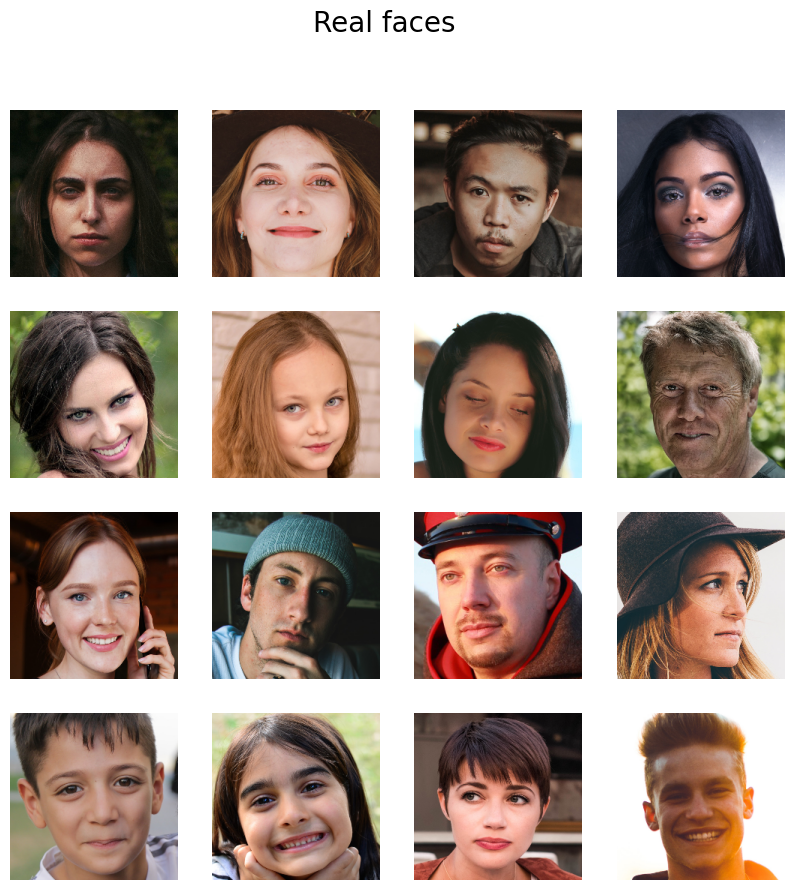

In [19]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

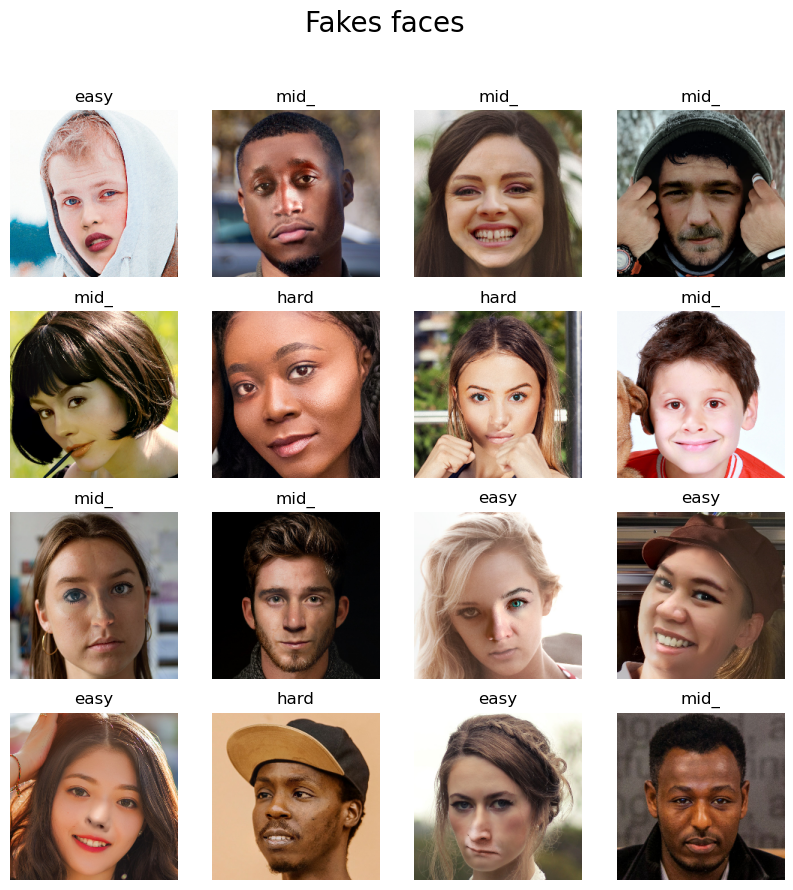

In [20]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [21]:
dataset_path = "Real and Fake Face Detection Dataset"

In [22]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [23]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [24]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


In [25]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(96,96,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [27]:
from keras.optimizers import SGD, RMSprop
opt = SGD(learning_rate=0.01) 

In [29]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
            BatchNormalization(),
            Dense(512, activation = "relu"),
            GlobalAveragePooling2D(),
            
            Dense(256, activation = "relu"),
            
            Dropout(0.5),

            # Dense(32, activation = "relu"),
            # Dropout(0.3),
            Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
def scheduler(epoch):
    if epoch <= 1:
        return 1.0
    elif epoch > 2 and epoch <= 10:
        return 0.1 
    elif epoch > 10 and epoch <= 15:
        return 0.01 
    else:
        return 0.001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [32]:
hist = model.fit(train,
                 epochs=20,
                 callbacks=[lr_callbacks],
                 validation_data=val)  

Epoch 1/20


/Users/hasithapramuditha/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 384ms/step - accuracy: 0.5073 - loss: 8.1804 - val_accuracy: 0.5294 - val_loss: 0.7994 - learning_rate: 1.0000
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.5090 - loss: 0.7097 - val_accuracy: 0.5123 - val_loss: 0.7141 - learning_rate: 1.0000
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.5692 - loss: 0.6514 - val_accuracy: 0.5025 - val_loss: 0.7165 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.5904 - loss: 0.6572 - val_accuracy: 0.5368 - val_loss: 0.7221 - learning_rate: 0.1000
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.6305 - loss: 0.6378 - val_accuracy: 0.5000 - val_loss: 0.7792 - learning_rate: 0.1000
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.6322 - loss: 0.6268 - val_accuracy: 0.5466 - val_loss: 0.7899 - learning_rate: 0.1000
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - accuracy: 0.6483 - loss: 0.5954 - val_

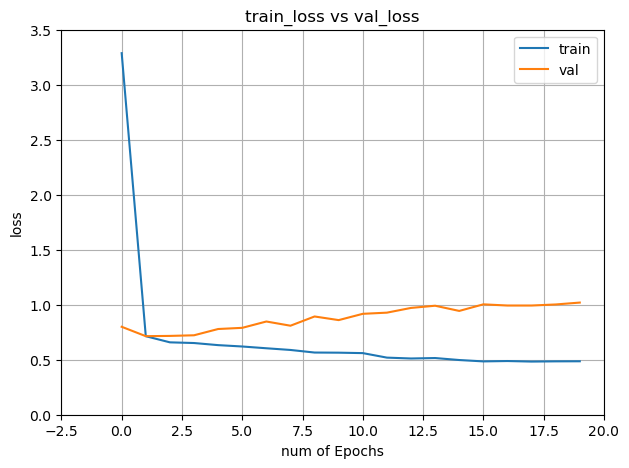

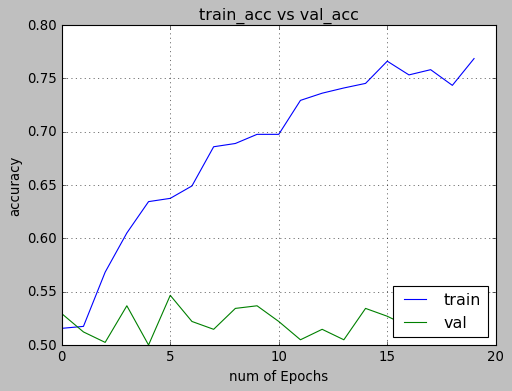

In [33]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.style.use(['classic'])

In [35]:
predictions = model.predict(val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step


/var/folders/jj/k5cpdpls3qj5fpnjrrjhldlr0000gn/T/ipykernel_13124/3398987636.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


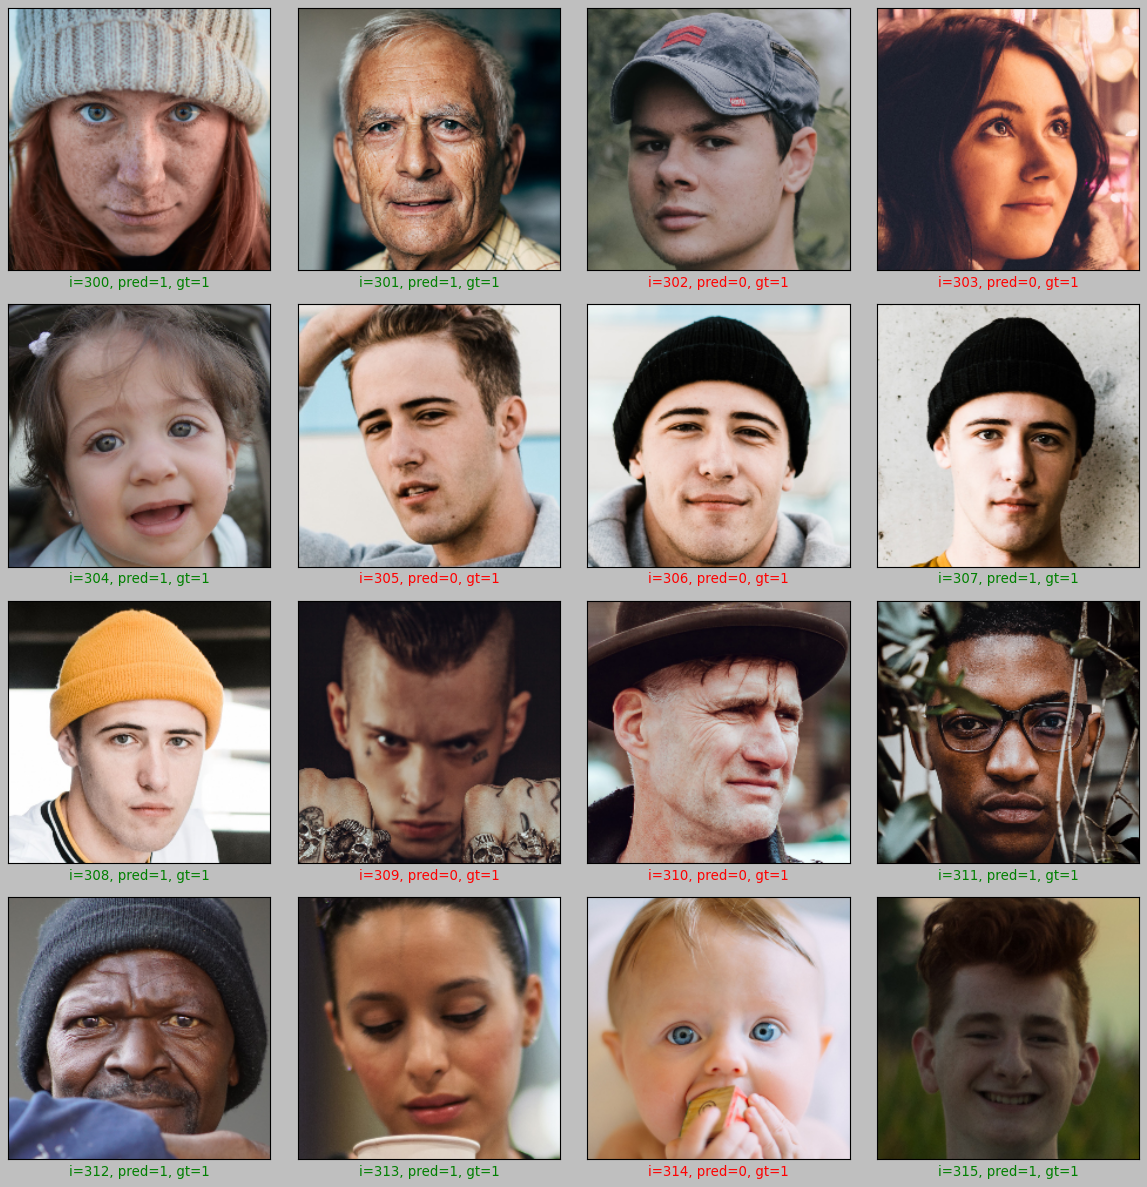

In [40]:
val_path = "Real and Fake Face Detection Dataset/"

plt.figure(figsize=(15,15))

start_index = 300

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()